### 1.Importing important libraries

In [ ]:
!pip install imutils
!pip install shutil

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=b4db0348c6849e2bc5a5c3ad02dbd745f49e5469a9083c6264ccf06a48b77c40
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [ ]:
import os
from os import listdir
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
import imutils
import shutil
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle




### 2. Data Import and Processing

In [ ]:
data_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection'

In [ ]:
# Create a directory for augmented images
os.makedirs('/kaggle/working/augmented-images', exist_ok = True)
os.makedirs('/kaggle/working/augmented-images/yes',exist_ok=True)
os.makedirs('/kaggle/working/augmented-images/no',exist_ok=True)

augmented_data_path='/kaggle/working/augmented-images'
augmented_yes=augmented_data_path+'/yes'
augmented_no=augmented_data_path+'/no'

Image_size=(224,224) #default image size

### 3. Data Augmentation

In [ ]:
def augmented_images(file_dir,no_samples_gen,save_img_dir):
    data_gen=ImageDataGenerator(rotation_range=15,
                               shear_range=0.1,
                               brightness_range=(0.3,1),
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
    for file in listdir(file_dir):
        image=cv2.imread(file_dir+'/'+file)
        #reshaping the image
        image=image.reshape((1,)+image.shape)
        save_prefix='augmented_'+file[:-4]
        #creating our counter
        i=0
        for batch in data_gen.flow(x=image,batch_size=1,save_to_dir=save_img_dir,save_prefix=save_prefix,save_format='jpg'):
            i+=1
            if i>no_samples_gen:
                break


In [ ]:
aug_dir=os.listdir('/kaggle/working/augmented-images/yes')
if len(aug_dir)==0:
    augmented_images(file_dir=data_dir+'/yes',no_samples_gen=6,save_img_dir=augmented_data_path+'/yes')
    augmented_images(file_dir=data_dir+'/no',no_samples_gen=9,save_img_dir=augmented_data_path+'/no')
else:
    print(len(aug_dir))

In [ ]:
def load_data(dir_list):
    #load imaages in directory
    X=[]
    y=[]
    for  directory in dir_list:
        for filename in listdir(directory):
            image=cv2.imread(directory+'/'+filename)
            X.append(image)
            if directory[-3:]=='yes':
                y.append([1])
            else:
                y.append([0])
    X=np.array(X)
    y=np.array(y)
    #To shuffle our data
    X,y=shuffle(X,y)
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
def split_data(X,y,test_size=0.3):
    X_train,X_test_val,y_train,y_test_val=train_test_split(X,y,test_size=test_size)
    X_test,X_val,y_test,y_val=train_test_split(X_test_val,y_test_val,test_size=0.5)
    return X_train,y_train,X_val,y_val,X_test,y_test

In [ ]:
def plot_data(X,y,labels_dict,n=50):
    for index in range(len(labels_dict)):
        imgs=X[np.argwhere(y==index)][:n]
        col=10
        i=int(n/col)
        plt.figure(figsize=(15,6))
        c=1
        for img in imgs:
            plt.subplot(i,col,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c+=1
        plt.suptitle('Tumor Classification {}'.format(labels_dict[index]))
        plt.show()


In [ ]:
X_train,y_train=load_data([augmented_yes, augmented_no])

Number of examples is: 2065
X shape is: (2065,)
y shape is: (2065, 1)


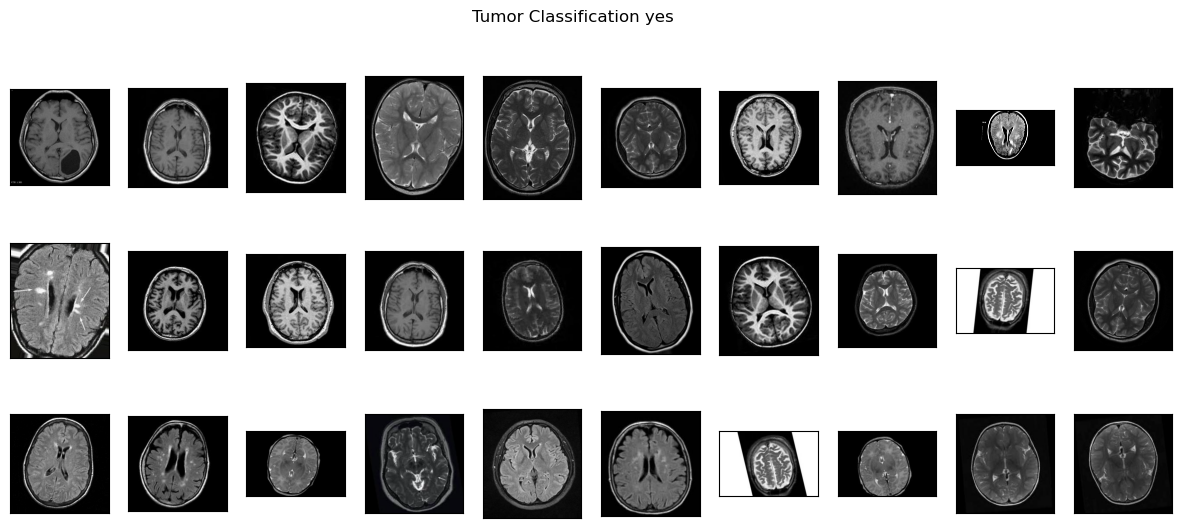

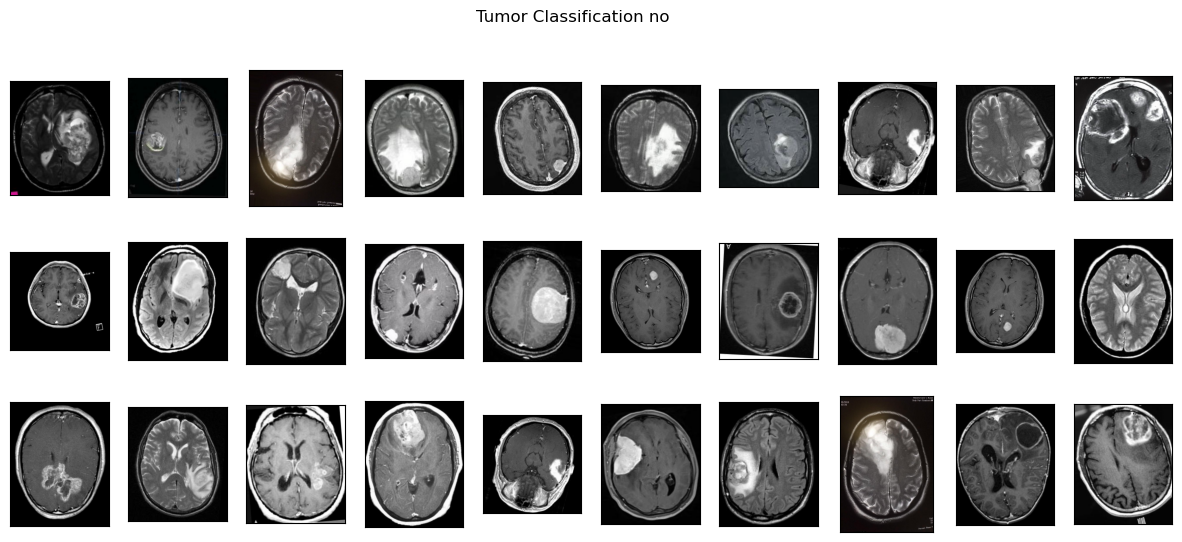

In [ ]:
plot_data(X_train,y_train,['yes','no'],30)

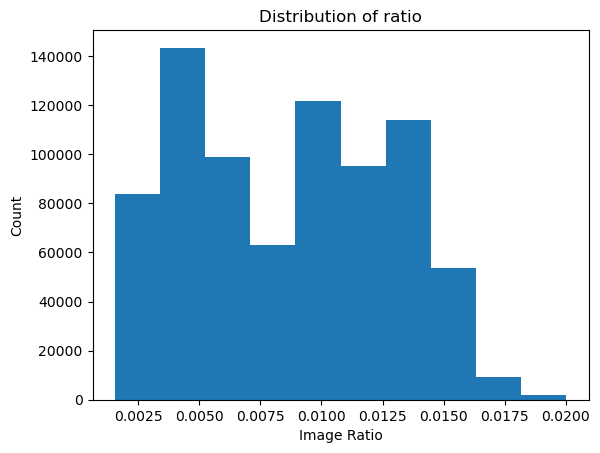

In [ ]:
SIZE=[]
for set in (X_train):
    for img in set:
        SIZE.append(img.shape[1]/img.shape[0])
plt.hist(SIZE)
plt.title('Distribution of ratio')
plt.xlabel('Image Ratio')
plt.ylabel('Count')
plt.show()



In [ ]:
del SIZE

In [ ]:
def crop_brain_cnt(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
     # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [ ]:
img_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y104.jpg'
img=cv2.imread(img_dir)
img=cv2.resize(
img,
dsize=Image_size,
interpolation=cv2.INTER_CUBIC)

gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
gray=cv2.GaussianBlur(gray,(5,5),0)
#Perform image thresholding, erosion, and dilation
thresh=cv2.threshold(gray,45,255,cv2.THRESH_BINARY)[1]
thresh=cv2.erode(thresh,None,iterations=2)
thresh=cv2.dilate(thresh,None,iterations=2)
#Find the extreme contours in thresholded image
cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts=imutils.grab_contours(cnts)
c=max(cnts,key=cv2.contourArea)
#To find extreme points
extLeft=tuple(c[c[:,:,0].argmin()][0])
extRight=tuple(c[c[:,:,0].argmax()][0])
extTop=tuple(c[c[:,:,0].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

#To add the contour to images
img_cnt=cv2.drawContours(img.copy(),[c],-1,(0,255,255),4)

#add extreme points
img_pnt=cv2.circle(img_cnt.copy(),extLeft,8,(0,0,255),-1)
img_pnt=cv2.circle(img_pnt,extRight,8,(0,255,0),-1)
img_pnt=cv2.circle(img_pnt,extTop,8,(255,0,0),-1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


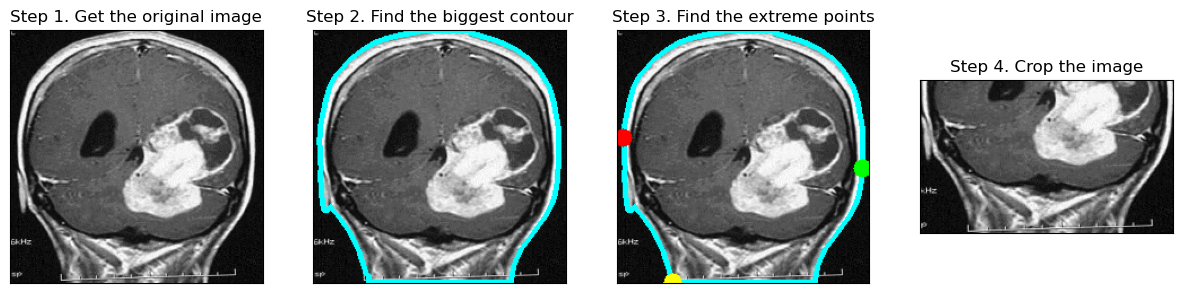

In [ ]:
titles = [
    'Step 1. Get the original image',
    'Step 2. Find the biggest contour',
    'Step 3. Find the extreme points',
    'Step 4. Crop the image'
]

images = [img, img_cnt, img_pnt, new_img]

plt.figure(figsize=(15, 6))

for i in range(4):
    plt.subplot(141 + i)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[i])

plt.show()


In [ ]:
def Crop_Data(train):
    X=[]
    y=[]
    for img in train:
        image=crop_brain_cnt(img,plot=False)
        X.append(image)
    X=np.array(X)
    return X

In [ ]:
X=Crop_Data(X_train)

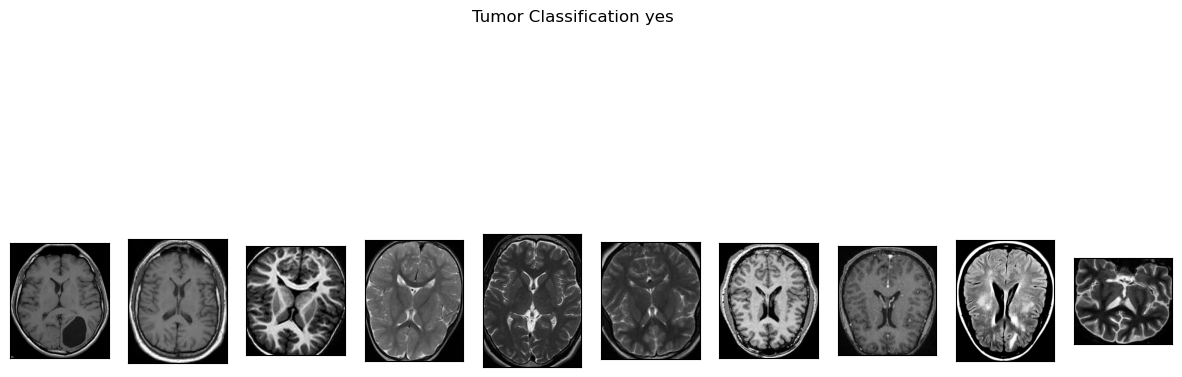

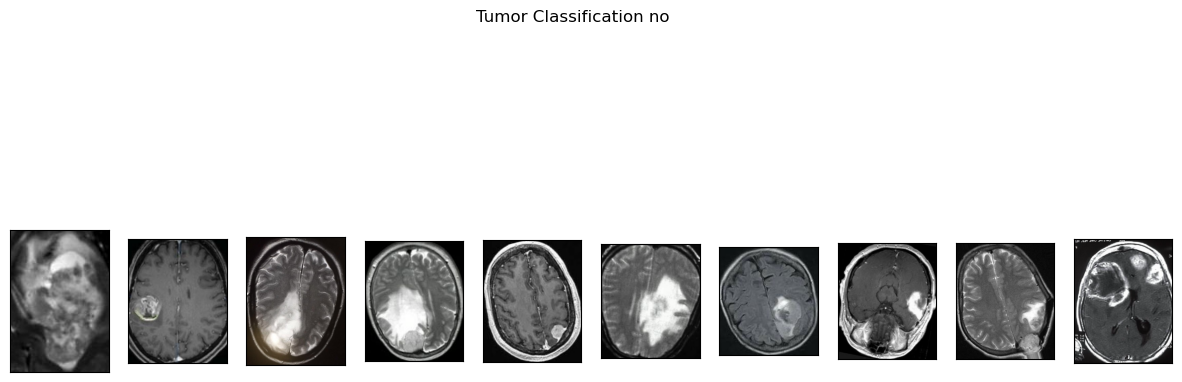

In [ ]:
plot_data(X,y_train,['yes','no'],10)

In [ ]:
def data_resize(train):
    X=[]
    y=[]

    IMG_WIDTH,IMG_HEIGHT=(240,240)
    for img in train:
        image=cv2.resize(img,dsize=(IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_CUBIC)
        image=image/255
        #convert our image to numpy array
        X.append(image)
    X=np.array(X)
    return X

In [ ]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)

X = data_resize(X)
y = y_train

In [ ]:
img=cv2.imread('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/11 no.jpg')
img_to_arr=(np.round(np.array(img)*255)).astype(np.uint8)
#flatten the image
img_to_arr=img_to_arr.flatten()

img_yes=cv2.imread('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y101.jpg')
img_yes_arr=(np.round(np.array(img_yes)*255)).astype(np.uint8)
#flatten the yes image
img_yes_arr=img_yes_arr.flatten()

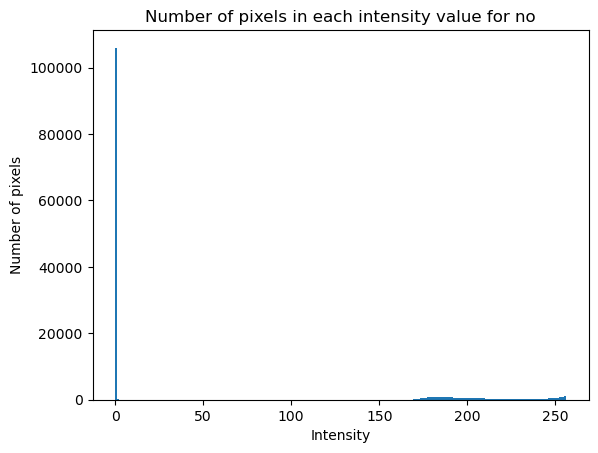

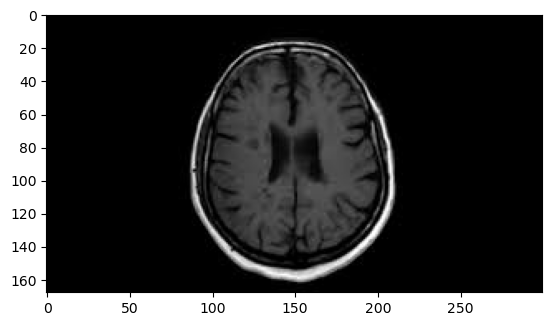

In [ ]:
# plot histogram
plt.hist(img_to_arr, bins = 256, range = [0,256])
plt.title("Number of pixels in each intensity value for no")
plt.xlabel("Intensity")
plt.ylabel("Number of pixels")
plt.show()

plt.imshow(img)
plt.show()

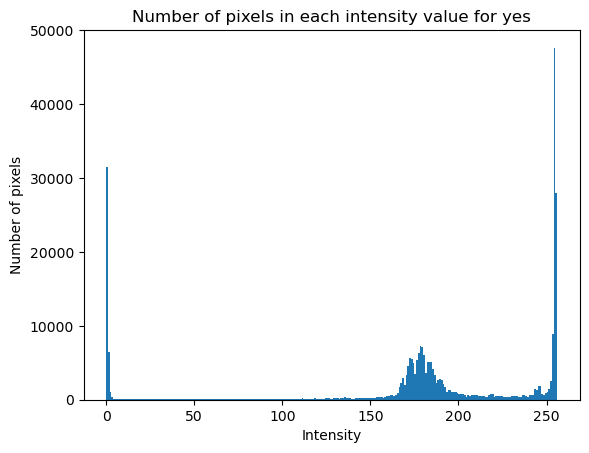

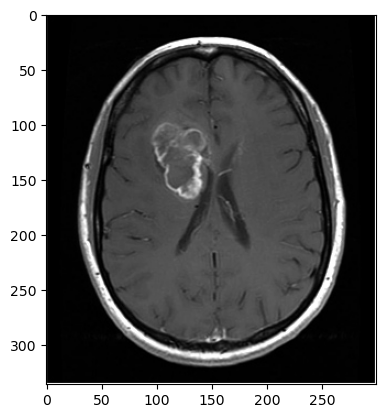

In [ ]:
plt.hist(img_yes_arr,bins=256,range=[0,256])
plt.title("Number of pixels in each intensity value for yes")
plt.xlabel("Intensity")
plt.ylabel("Number of pixels")
plt.show()

plt.imshow(img_yes)
plt.show()


### Data Visualization

In [ ]:
X_train,y_train,X_val,y_val,X_test,y_test=split_data(X,y,test_size=0.05)

In [ ]:
del X
del y

In [ ]:
print("The number of training set is {}".format(X_train.shape[0]))
print("The number of validation set is {}".format(X_val.shape[0]))
print("The number of test set is {}".format(X_test.shape[0]))

The number of training set is 1961
The number of validation set is 52
The number of test set is 52


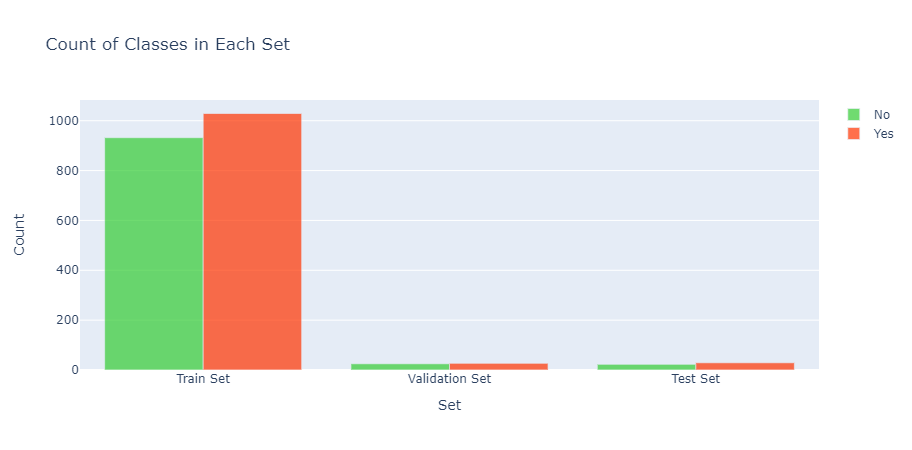

In [ ]:
# Import necessary libraries
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import numpy as np

# Initialize Plotly notebook mode
init_notebook_mode(connected=True)

# Initialize an empty dictionary to store class counts
class_counts = {0: [], 1: []}

# Iterate through datasets and calculate class counts
for dataset in (y_train, y_val, y_test):
    class_counts[0].append(np.sum(dataset == 0))
    class_counts[1].append(np.sum(dataset == 1))

# Create a bar trace for the 'No' class
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=class_counts[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)

# Create a bar trace for the 'Yes' class
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=class_counts[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

# Combine bar traces into a data list
data = [trace0, trace1]

# Define layout for the bar chart
layout = go.Layout(
    title='Count of Classes in Each Set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

# Create a Figure using data and layout
fig = go.Figure(data=data, layout=layout)

# Display the figure using Plotly iplot function
iplot(fig)


### Building our Convolutional Neural Network

In [ ]:
def build_model(input_shape):
    # Input layer
    X_input = Input(input_shape)

    # Convolutional layer with padding
    X = ZeroPadding2D((2, 2))(X_input)
    X = Conv2D(32, (7, 7), strides=(1, 1))(X)

    # Batch normalization for regularization
    X = BatchNormalization(axis=3, name='bn0')(X)

    # Activation function
    X = Activation('relu')(X)

    # Max pooling layers
    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)

    # Flatten the output for fully connected layers
    X = Flatten()(X)

    # Fully connected layer with sigmoid activation
    X = Dense(1, activation='sigmoid')(X)

    # Create the model
    model = Model(inputs=X_input, outputs=X)

    return model


In [ ]:
IMG_SHAPE=(IMG_WIDTH,IMG_HEIGHT,3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                           

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x=X_train,y=y_train,batch_size=32,epochs=15,validation_data=(X_val,y_val))

Epoch 1/15
62/62 [==============================] - 15s 64ms/step - loss: 0.7870 - accuracy: 0.6400 - val_loss: 0.6297 - val_accuracy: 0.5962
Epoch 2/15
62/62 [==============================] - 4s 57ms/step - loss: 0.5021 - accuracy: 0.7527 - val_loss: 0.5583 - val_accuracy: 0.7308
Epoch 3/15
62/62 [==============================] - 3s 54ms/step - loss: 0.4671 - accuracy: 0.7853 - val_loss: 0.4661 - val_accuracy: 0.8462
Epoch 4/15
62/62 [==============================] - 3s 55ms/step - loss: 0.3476 - accuracy: 0.8526 - val_loss: 0.3925 - val_accuracy: 0.9231
Epoch 5/15
62/62 [==============================] - 3s 54ms/step - loss: 0.3229 - accuracy: 0.8608 - val_loss: 0.4001 - val_accuracy: 0.8462
Epoch 6/15
62/62 [==============================] - 3s 55ms/step - loss: 0.2937 - accuracy: 0.8848 - val_loss: 0.3561 - val_accuracy: 0.8462
Epoch 7/15
62/62 [==============================] - 3s 55ms/step - loss: 0.2740 - accuracy: 0.8904 - val_loss: 0.3188 - val_accuracy: 0.8654
Epoch 8/15
6

### Lets analyse our accuracy

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Using VGG-16 Pre-Trained Network

In [ ]:
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import layers
from keras.models import Model,Sequential
from keras.optimizers import Adam,RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
#load model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape=IMG_SHAPE
)

In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(vgg16_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x=X_train,y=y_train,batch_size=32,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
62/62 [==============================] - 22s 259ms/step - loss: 0.5570 - accuracy: 0.7297 - val_loss: 0.2228 - val_accuracy: 0.9808
Epoch 2/10
62/62 [==============================] - 9s 147ms/step - loss: 0.2729 - accuracy: 0.8965 - val_loss: 0.2021 - val_accuracy: 0.9231
Epoch 3/10
62/62 [==============================] - 9s 147ms/step - loss: 0.1964 - accuracy: 0.9332 - val_loss: 0.1379 - val_accuracy: 0.9615
Epoch 4/10
62/62 [==============================] - 9s 149ms/step - loss: 0.1295 - accuracy: 0.9735 - val_loss: 0.1043 - val_accuracy: 0.9808
Epoch 5/10
62/62 [==============================] - 9s 151ms/step - loss: 0.1168 - accuracy: 0.9720 - val_loss: 0.1070 - val_accuracy: 0.9808
Epoch 6/10
62/62 [==============================] - 9s 151ms/step - loss: 0.0894 - accuracy: 0.9832 - val_loss: 0.0713 - val_accuracy: 1.0000
Epoch 7/10
62/62 [==============================] - 9s 152ms/step - loss: 0.0800 - accuracy: 0.9862 - val_loss: 0.0636 - val_accuracy: 1.0000
Epoch

In [ ]:
history=model.history.history

2/2 [==============================] - 0s 182ms/step
Val Accuracy = 1.00


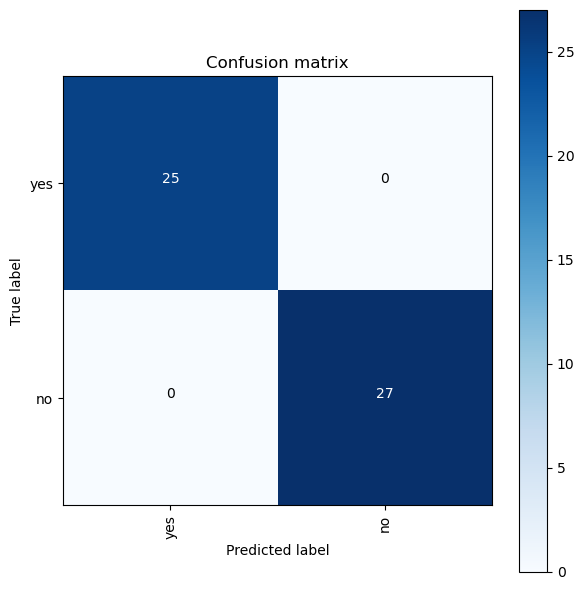

In [ ]:
labels = ['yes','no']
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

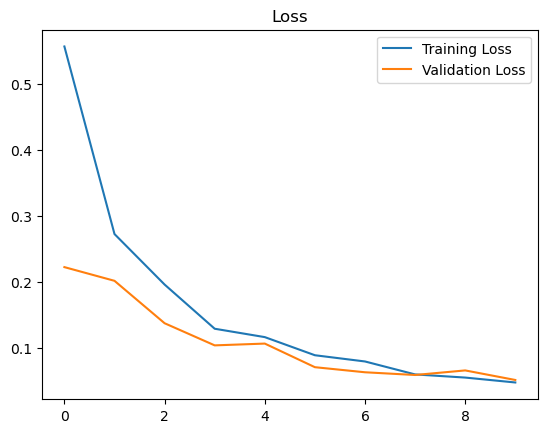

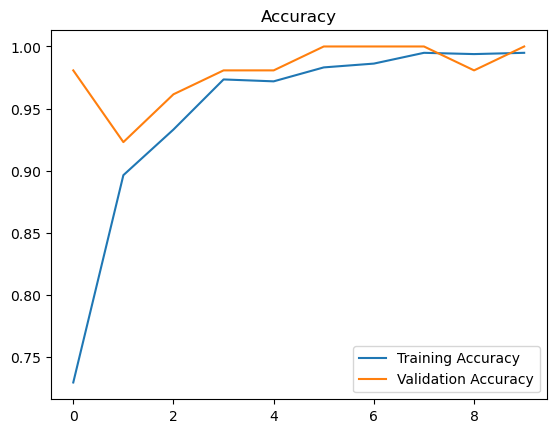

In [ ]:
plot_metrics(history)

2/2 [==============================] - 0s 132ms/step
Val Accuracy = 1.00


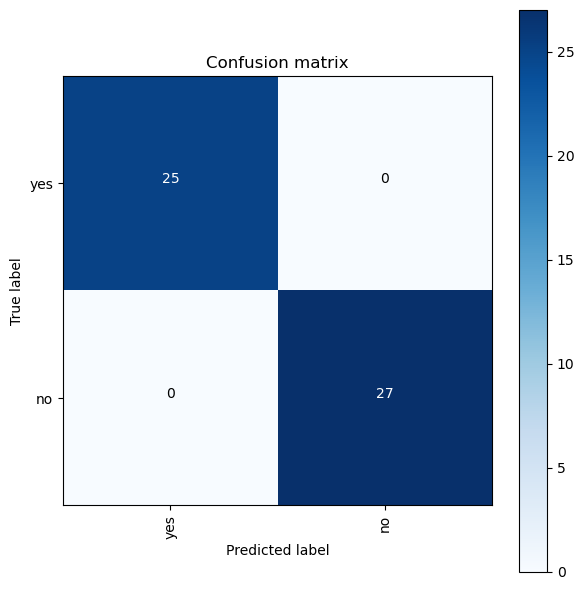

In [ ]:
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

### Using ResNet50

In [ ]:
#load model
resnet_weight_path = '/kaggle/input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(resnet50_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_1 (Dropout)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 131073    
                                                                 
Total params: 23,718,785
Trainable params: 131,073
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x=X_train,y=y_train,batch_size=32,epochs=15,validation_data=(X_val,y_val))

Epoch 1/15
62/62 [==============================] - 15s 158ms/step - loss: 1.0282 - accuracy: 0.6063 - val_loss: 0.4152 - val_accuracy: 0.8269
Epoch 2/15
62/62 [==============================] - 7s 115ms/step - loss: 0.6668 - accuracy: 0.6884 - val_loss: 0.2980 - val_accuracy: 0.8846
Epoch 3/15
62/62 [==============================] - 7s 116ms/step - loss: 0.8234 - accuracy: 0.6747 - val_loss: 0.4956 - val_accuracy: 0.7500
Epoch 4/15
62/62 [==============================] - 7s 117ms/step - loss: 0.9487 - accuracy: 0.6752 - val_loss: 0.2015 - val_accuracy: 0.9231
Epoch 5/15
62/62 [==============================] - 7s 114ms/step - loss: 0.7873 - accuracy: 0.7236 - val_loss: 0.5389 - val_accuracy: 0.7692
Epoch 6/15
62/62 [==============================] - 7s 114ms/step - loss: 0.5928 - accuracy: 0.7588 - val_loss: 0.6529 - val_accuracy: 0.7308
Epoch 7/15
62/62 [==============================] - 7s 117ms/step - loss: 0.5535 - accuracy: 0.7772 - val_loss: 0.4776 - val_accuracy: 0.7308
Epoch

In [ ]:
history=model.history.history

2/2 [==============================] - 1s 98ms/step
Val Accuracy = 0.73


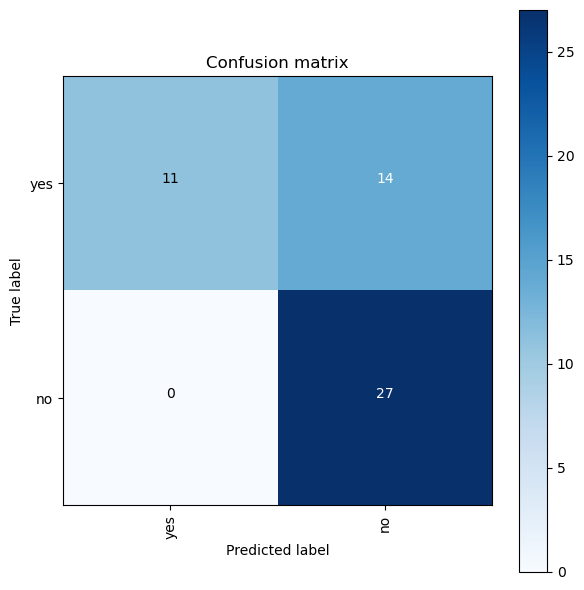

In [ ]:
labels = ['yes','no']
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

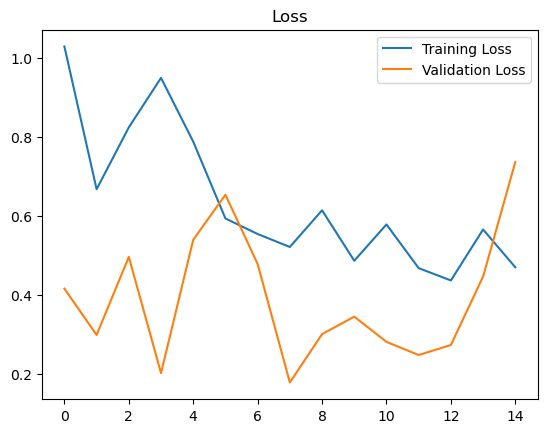

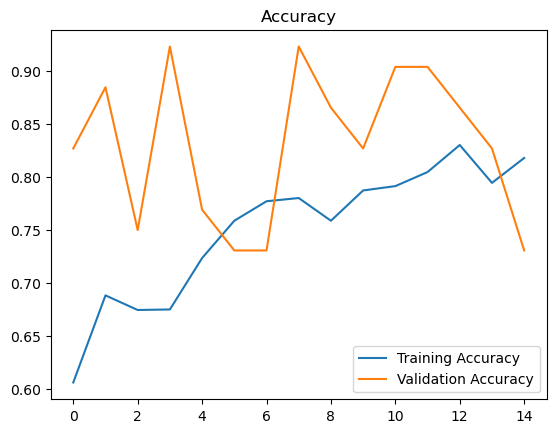

In [ ]:
plot_metrics(history)

In [ ]:
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)